In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path 
import time

import random
import pickle as pic
import scipy as sc
import numpy as np

import numpy as np
import librosa
import soundfile as sf
import pyroomacoustics as pra

import matplotlib.pyplot as plt

In [3]:
from alphaMusic.utils.geo_utils import cart2sph, sph2cart

In [66]:
data_dir = '../data/'
results_dir = './results/'

gpu = 0
seed = 666

RT60 = 0.1
snr = 100

alpha = 2
n_srcs = 3
n_mics = 5

n_fft = 1024
ac_model='far'
x_acc=5
y_acc=20

minF = 1000
maxF = 4000

In [67]:
# set up folders
data_dir = Path(data_dir)
results_dir = Path(results_dir, 'RT60={}/alpha={}/'.format(RT60, alpha))
results_dir.mkdir(parents=True, exist_ok=True)

# set up random seed
np.random.seed(seed)
random.seed(seed)

In [68]:
# GET DATA
data_dir = data_dir / Path("LibriSpeech", "dev-clean", "84", "121123")
file_paths = list(data_dir.glob("*.flac"))[:n_srcs]
random.shuffle(file_paths)

In [69]:
# allocate memory
id_biggest_file = np.argmax([os.path.getsize(file) for file in file_paths])
tmp_wav, fs = sf.read(file_paths[id_biggest_file])
max_length = len(tmp_wav)
speech_dry_NT = np.zeros([n_srcs, max_length], dtype=np.float32)

# get anechoic speech
obs_MT = np.zeros([n_mics, max_length], dtype=np.float32)
Name_file = ''
for id_fp, file_path in enumerate(file_paths):
    name_file = file_path.name.split('.')[0]
    if id_fp == 0:
        Name_file += name_file
    else:
        Name_file += '_{}'.format(name_file)
    print('source {}: {}'.format(id_fp + 1, name_file))
    tmp_wav, fs = sf.read(file_path)
    tmp_wav /= np.std(tmp_wav)
    speech_dry_NT[id_fp, :len(tmp_wav)] = tmp_wav

source 1: 84-121123-0015
source 2: 84-121123-0020
source 3: 84-121123-0011


In [86]:
ref_doa = np.random.randint(0,180) # in degree
ref_doa = 90
# the other 2 sources are +- 30 degree
doas = np.array([ref_doa, ref_doa+30, ref_doa-30])
doas = np.mod(doas, 360)

distances = 3*[1.5] # metres
elevations = 3*[0]

(<Figure size 432x288 with 1 Axes>, <Axes3D:>)

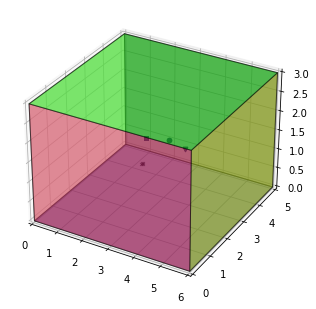

In [87]:
ref_source_doa = np.random.randint(0,360)


# simulate reverberation
room_dim = [6.0, 5.0, 3.0]  # meters
if RT60 < 0.2:
    e_absorption = 0.99
    max_order = 0
else:
    e_absorption, max_order = pra.inverse_sabine(RT60, room_dim)

room = pra.ShoeBox(
    room_dim, fs=fs, materials=pra.Material(e_absorption), max_order=max_order
)

 # add spherical array
mic_center = np.c_[[3.2, 1.5, 1.5]]
mic_radius = 0.04
R_3M = pra.circular_2D_array(mic_center[:2, 0], n_mics, 0, mic_radius)
R_3M = np.concatenate((R_3M, np.ones((1, n_mics)) * mic_center[2, 0]), axis=0)
pos_N = np.zeros((n_srcs)).astype(np.float32)
room.add_microphone_array(R_3M)

# add sources

true_positions = {}
for n in range(n_srcs):
    
    az = doas[n]
    el = elevations[n]
    dst = distances[n]
    
    src_sph = np.array([[dst, az, el]]).T
    src_cart_rel = sph2cart(src_sph)
    src_cart_abs = src_cart_rel + mic_center

    
    room.add_source(src_cart_abs, signal=speech_dry_NT[n])

    true_positions['abs'] = src_cart_abs
    true_positions['sph'] = src_sph
    
    pos_N[n] = np.deg2rad(az)


room.plot()

In [88]:
room.simulate()

In [89]:
# to STFT
for m in range(n_mics):
    t = len(room.mic_array.signals[m, :])
    tmp = librosa.core.stft(np.asfortranarray(room.mic_array.signals[m, :]),
                            n_fft=n_fft,
                            hop_length=int(n_fft/4))
    if m == 0:
        obs_FTM = np.zeros([tmp.shape[0], tmp.shape[1], n_mics], dtype=complex)
    obs_FTM[..., m] = tmp
print(obs_FTM.shape)

(513, 434, 5)


In [90]:
from alphaMusic.alphaMUSIC import AlphaMUSIC

localizer = AlphaMUSIC(n_source=n_srcs,
            seed=seed, alpha=alpha, ac_model=ac_model, x_acc=x_acc, y_acc=y_acc,
            mic_pos=R_3M, source_pos=pos_N, P_prime=50, xp=np)

localizer.load_spectrogram(obs_FTM, minF=minF, maxF=maxF,
                        nfft=n_fft, fs=fs)

localizer.file_id = Name_file

localizer.localize(save_parameter=True, save_pos=True,
                save_RMS=True, save_corr=False, SAVE_PATH=results_dir)

real_pos:[1.5707964 2.0943952 1.0471976], est_pos:[2.0943951  1.04719755 1.57079633]
RMS:{'az_RMS': 4.530141164111946e-08}


In [91]:
azimuth_recon = np.rad2deg(localizer.est_pos_N)
print(azimuth_recon)
print(np.rad2deg(pos_N))

[ 60.  90. 120.]
[ 90. 120.  60.]


In [92]:
doa = pra.doa.algorithms["MUSIC"](R_3M, fs, n_fft, c=343, num_src=3)

# this call here perform localization on the frames in X
doa.locate_sources(obs_FTM.transpose([2,0,1]), freq_range=[minF, maxF])

print(np.rad2deg(doa.azimuth_recon))
print(doa.azimuth_recon)
print(pos_N)

[120.  60.  89.]
[2.0943951  1.04719755 1.55334303]
[1.5707964 2.0943952 1.0471976]


In [97]:
doa = pra.doa.algorithms["NormMUSIC"](R_3M, fs, n_fft, c=343, num_src=3)

# this call here perform localization on the frames in X
doa.locate_sources(obs_FTM.transpose([2,0,1]), freq_range=[minF, maxF])

print(np.rad2deg(doa.azimuth_recon))
print(doa.azimuth_recon)
print(pos_N)

[120.  60.  89.]
[2.0943951  1.04719755 1.55334303]
[1.5707964 2.0943952 1.0471976]


In [98]:
doa = pra.doa.algorithms["SRP"](R_3M, fs, n_fft, c=343, num_src=3)

# this call here perform localization on the frames in X
doa.locate_sources(obs_FTM.transpose([2,0,1]), freq_range=[minF, maxF])

print(np.rad2deg(doa.azimuth_recon))
print(doa.azimuth_recon)
print(pos_N)

[349. 277. 115.]
[6.09119909 4.83456203 2.00712864]
[1.5707964 2.0943952 1.0471976]
